# Modeling Ternary Body Formation:
## The T Cell - Antigen - Tumor Cell model

### Importing the important packages to simulate the model.

In [1]:
#General imports
import math
import numpy as np
import pandas as pd
import seaborn as sns

#Matplotlib specific imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from matplotlib import cm
from matplotlib.legend import Legend
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#Scipy specific imports
from scipy.stats import entropy
from scipy.integrate import odeint
from scipy.optimize import curve_fit

### Definition of the function which handles optimization of the ODE Ternary Body model

In [2]:
def rxn(C,t):
        #Loading the global variable reaction rates
        kf1 = kf4 = k[0]                                             
        kr1 = kr4 = k[1]                                             
        kf2 = kf3 = k[2]                                             
        kr2 = kr3 = k[3]                                             
        
        #Loading the initial concentrations
        C_snap = C[0]                   #initial concentration of free T Cell receptor
        C_anti = C[1]                   #initial concentration of free antibody
        C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
        C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
        C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
        C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
        
        #Separation of key equation terms for simplicity
        term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody
        term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
        term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
        term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
        term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
        term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
        term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
        term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body

        #ODEs that model the dynamic change in concentration of each chemical species
        d_C_snap_dt = - term1 + term2 - term7 + term8                         #change in free T Cell receptor
        d_C_anti_dt = - term1 + term2 - term3 + term4                         #change in free antibody
        d_C_tumo_dt = - term3 + term4 - term5 + term6                         #change in free Tumor cell receptor
        d_C_snap_anti_dt = + term1 - term2 - term5 + term6                    #change in bound T Cell - Antibody
        d_C_anti_tumo_dt = + term3 - term4 - term7 + term8                    #change in bound Tumor Cell - Antibody
        d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8               #change in Ternary Body
        
        return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

In [3]:
def fitfunc(ab, fit1, fit2, fit3, fit4, fit5):  #we could expand this to include the initial concentration of tumor and tcell...
    'Function that returns ABC computed from an ODE for 4 ks'
    global Concentration_of_T_Cells, Concentration_of_Tumor_Cells, k_norm_vector
    k1 = fit1 * TCell.iloc[0][1]
    k2 = fit2 * Antibodies['k_on'][type_of_antibody]
    k3 = fit3 * Antibodies['k_off'][type_of_antibody]
    C0 = fit4 * Concentration_of_T_Cells
    C2 = fit5 * Concentration_of_Tumor_Cells
    C = [C0,0,C2,0,0,0]

    def myode(C, t):
        #Loading the global variable reaction rates
        kf1 = kf4 = k1                                            
        kr1 = kr4 = 0                                            
        kf2 = kf3 = k2                                             
        kr2 = kr3 = k3                                             
        
        #Loading the initial concentrations
        C_snap = C[0]                   #initial concentration of free T Cell receptor
        C_anti = C[1]                   #initial concentration of free antibody
        C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
        C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
        C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
        C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
        
        #Separation of key equation terms for simplicity
        term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody
        term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
        term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
        term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
        term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
        term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
        term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
        term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body

        #ODEs that model the dynamic change in concentration of each chemical species
        d_C_snap_dt = - term1 + term2 - term7 + term8                         #change in free T Cell receptor
        d_C_anti_dt = - term1 + term2 - term3 + term4                         #change in free antibody
        d_C_tumo_dt = - term3 + term4 - term5 + term6                         #change in free Tumor cell receptor
        d_C_snap_anti_dt = + term1 - term2 - term5 + term6                    #change in bound T Cell - Antibody
        d_C_anti_tumo_dt = + term3 - term4 - term7 + term8                    #change in bound Tumor Cell - Antibody
        d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8               #change in Ternary Body
        
        return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])
    
    build = []
    time = np.linspace(0,86400,86400)
    for init in ab:
        C[1] = init
        C_array = odeint(myode, C, time)
        build.append(C_array[-1,5])
        
    build = [float(i)/max(build) for i in build]

    return build

In [4]:
def r_squared(a,b):
    ybar = np.sum(a)/len(a)          
    ssreg = np.sum((b-ybar)**2)   
    sstot = np.sum((a - ybar)**2)    
    r_squared = 1 - (ssreg / sstot)
    return r_squared
    
def sum_sq_error(a,b):
    res = a - b
    ssq = np.sum(res**2)
    return ssq

def KL_div(a,b):
    res = entropy(a, b)
    return res

def calculate_errors(namer,booler,actual,sim):
    SSE = sum_sq_error(actual,sim)
    Rsq = r_squared(actual,sim)
    KLd = KL_div(actual,sim)
    if booler:
        results = 'Results for ' + str(namer) + ': \n'
        results = results + 'UNFIT SIMULATION \n'
        results = results + '     SSE = %1.3f \n' % SSE
        results = results + '     Rsq = %1.3f \n' % Rsq
        results = results + '     KLd = %1.3f \n \n' % KLd
    else:
        results = 'Results for ' + str(namer) + ': \n'
        results = results + 'FITTED SIMULATION \n'
        results = results + '     SSE = %1.3f \n' % SSE
        results = results + '     Rsq = %1.3f \n' % Rsq
        results = results + '     KLd = %1.3f \n \n' % KLd
    return results

    
def write_me_up(namer,actual,sim,fit,fitted,error):
    file_name = namer[:-4]+'.txt'
    results1 = calculate_errors(namer,1,actual,sim)
    error_before = '{:1.2f}'.format(sum_sq_error(actual,sim))
    results2 = calculate_errors(namer,0,actual,fit)
    error_after = '{:1.2f}'.format(sum_sq_error(actual,fit))
    file = open(file_name, "w") 
    file.write(results1) 
    file.write(results2)
    file.write('Fit = ' + str(fitted) + '\n')
    file.write('Error = ' + str(error)+ '\n')
    file.close()
    return error_before, error_after


### Experimental Setup

In [210]:
#User defined values to determine which simulation to run and compare against experimental values
type_of_tcell = "SN"            #Options = "SN" for synNotch, or "CAR" for SNAP-CAR                         OLD tceller
type_of_antibody = "FMC63"      #Options = "FMC63", "Rituximab", "Cetuximab", or "Herceptin"                OLD antibody

#Reading in the Experimental Data from the "Data" Folder
experiment = type_of_tcell + "_" + type_of_antibody                                                      #   OLD current
df_fit = pd.read_excel('Data/ExperimentalData.xlsx', sheet_name=experiment)

#Reading in the Literature Values from the "Data" Folder
TCell = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='TCell',index_col='TCR')
Receptors = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='Receptors',index_col='Target')
Antibodies = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='Antibodies',index_col='Antibody')

In [211]:
#normalizing the experimental data
df_data = df_fit.iloc[:,0]
df_xdata = df_data / 1e-9 / Antibodies.loc[type_of_antibody]['MW'] / 1000 / 1e6 / 1e-3 #conversion ug/mL to nM
df_ydata = (df_fit.iloc[:,10]-df_fit.iloc[:,10].min())/(df_fit.iloc[:,10].max()-df_fit.iloc[:,10].min()) #normalized to maximal ternary body formation
df_yerror = df_fit.iloc[:,12]/(df_fit.iloc[:,10].max()-df_fit.iloc[:,10].min())

In [212]:
#Average Trial Experimental Data
x_vals = df_fit.iloc[:,0].values
temp = df_fit.iloc[:,10]
y_vals_norm = (temp-temp.min())/(temp.max()-temp.min()) #normalized to maximal ternary body formation
y_vals = y_vals_norm.values
total = []
for i in range(0,len(x_vals)):
    row = [float(x_vals[i]),float(y_vals[i])]
    total.append(row)
exp_data_average = np.array(total)
# print(exp_data_average)

In [213]:
#Individual Trial Experimental Data
x_vals = df_fit.iloc[:,0].values
temp = df_fit.iloc[:,7:10]
y_vals_norm = (temp-temp.min())/(temp.max()-temp.min()) #normalized to maximal ternary body formation
y_vals = y_vals_norm.values
total = []
for i in range(0,len(x_vals)):
    for j in range(0,3):
        row = [float(x_vals[i]),float(y_vals[i][j])]
        total.append(row)
exp_data_alot = np.array(total)
# print(exp_data_alot)

In [214]:
#creating an empty list to store simulation data
data = []
antibody_nm = np.logspace(-4,2,100) #antibody in nM for simulation
# antibody_ug_axis = antibody_nm * 1/((10**-3) * (1000/Antibodies.loc[antibody]['MW']) * (10**9) ) #convert nM to ug/mL for plotting
antibody_ug_axis = antibody_nm * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

#Variables given for the experimental setup
Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
reaction_volume = 150                                     #150 uL reaction volume
number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

#Regular Parameters from before
receptor = Antibodies['Target'][type_of_antibody]
number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
number_of_receptors_per_tumor = int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

#Calculating the initial molecular concentrations
Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
Concentration_of_Antibody = 1 #1 nM, ususal value is a range

k_binding_snap_to_antibody = TCell.iloc[0][1]
k_release_snap_to_antibody = 0 #TCell.iloc[0][3]
k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

k = [k_binding_snap_to_antibody,\
     k_release_snap_to_antibody,\
     k_binding_antibody_to_tumor,\
     k_release_antibody_to_tumor] 

ternary_body = []

#the for loop to go over the range of the antibody concentrations
for anitbody in antibody_nm:
    Initial = [Concentration_of_T_Cells,anitbody,Concentration_of_Tumor_Cells,0,0,0]
    time = np.linspace(0,86400,86400)
    C = odeint(rxn,Initial,time)
    ternary_body.append(float((C[-1,5])))

data.append(ternary_body)

In [215]:
print(k_binding_snap_to_antibody)
print(k_binding_antibody_to_tumor)
print(k_release_antibody_to_tumor)
print(Concentration_of_T_Cells)
print(Concentration_of_Tumor_Cells)

2.8e-05
0.000624
0.00055
0.16605390404271644
1.1291665474904717


In [216]:
tot = [float(i)/max(data[0]) for i in data[0]]
ab_ug_x_axis = np.array([antibody_ug_axis])
sim_results = np.array([tot])
sim_array = np.concatenate((ab_ug_x_axis, sim_results), axis=0)
sim_array = sim_array.T

error_points_average = np.interp(exp_data_average[:,0], sim_array[:,0], sim_array[:,1])
error_points_alot = np.interp(exp_data_alot[:,0], sim_array[:,0], sim_array[:,1])
# print(error_points_average)

In [217]:
#Generating Plot Variables 
x_dots = exp_data_average[:,0]
y_actual_dots = exp_data_average[:,1]
y_actual_error = exp_data_average[:,1]
y_hat_dots = error_points_average
x_cont = sim_array[:,0]
#creating a polynomial fit to exp data to make it look nice?
z = np.polyfit(x_dots, y_actual_dots, 6)
p = np.poly1d(z)
y_actual_cont = p(x_cont)
y_hat_cont = sim_array[:,1]

#calculate Errors
# full_namer = 'SimulationWorkingPaper/' + str(current) +'.png'
# write_error(full_namer,y_actual_dots,y_hat_dots)

In [218]:
bounder = ((0.1,0.1,0.1,0.1,0.1),(10,10,10,10,10))
poer = [1,1,1,1,1]

k_fit, kcov = curve_fit(fitfunc, df_xdata, df_ydata, bounds=bounder, p0 = poer)
# k_fit, kcov = curve_fit(fitfunc, df_xdata, df_ydata, bounds=bounder, p0 = poer)

perr = np.sqrt(np.diag(kcov))
print("FIT")
print(k_fit)
print("ERROR")
print(perr)

k_fit[0] = k_fit[0]
k_fit[1] = k_fit[1]
k_fit[2] = k_fit[2]
k_fit[3] = k_fit[3]
k_fit[4] = k_fit[4]

# k_fit[0] = 1 
# k_fit[1] = 1 
# k_fit[2] = 1 
# k_fit[3] = 1 
# k_fit[4] = 1

x_fit = x_cont / 1e-9 / Antibodies.loc[type_of_antibody]['MW'] / 1000 / 1e6 / 1e-3 #conversion ug/mL to nM
y_fit = fitfunc(x_fit, k_fit[0], k_fit[1], k_fit[2], k_fit[3], k_fit[4])

#interpolate simulation points
y_fit_dots = np.interp(exp_data_average[:,0], x_cont, y_fit)

#calculate Errors
full_namer =  'Figures/' + str(experiment) +'.png'
error_before, error_after = write_me_up(full_namer,y_actual_dots,y_hat_dots,y_fit_dots,k_fit,perr)

FIT
[0.68238094 0.62961634 1.28322656 2.82903092 1.46892913]
ERROR
[ 1.79988246  3.00495167  7.93865137 14.34179023 20.32484433]


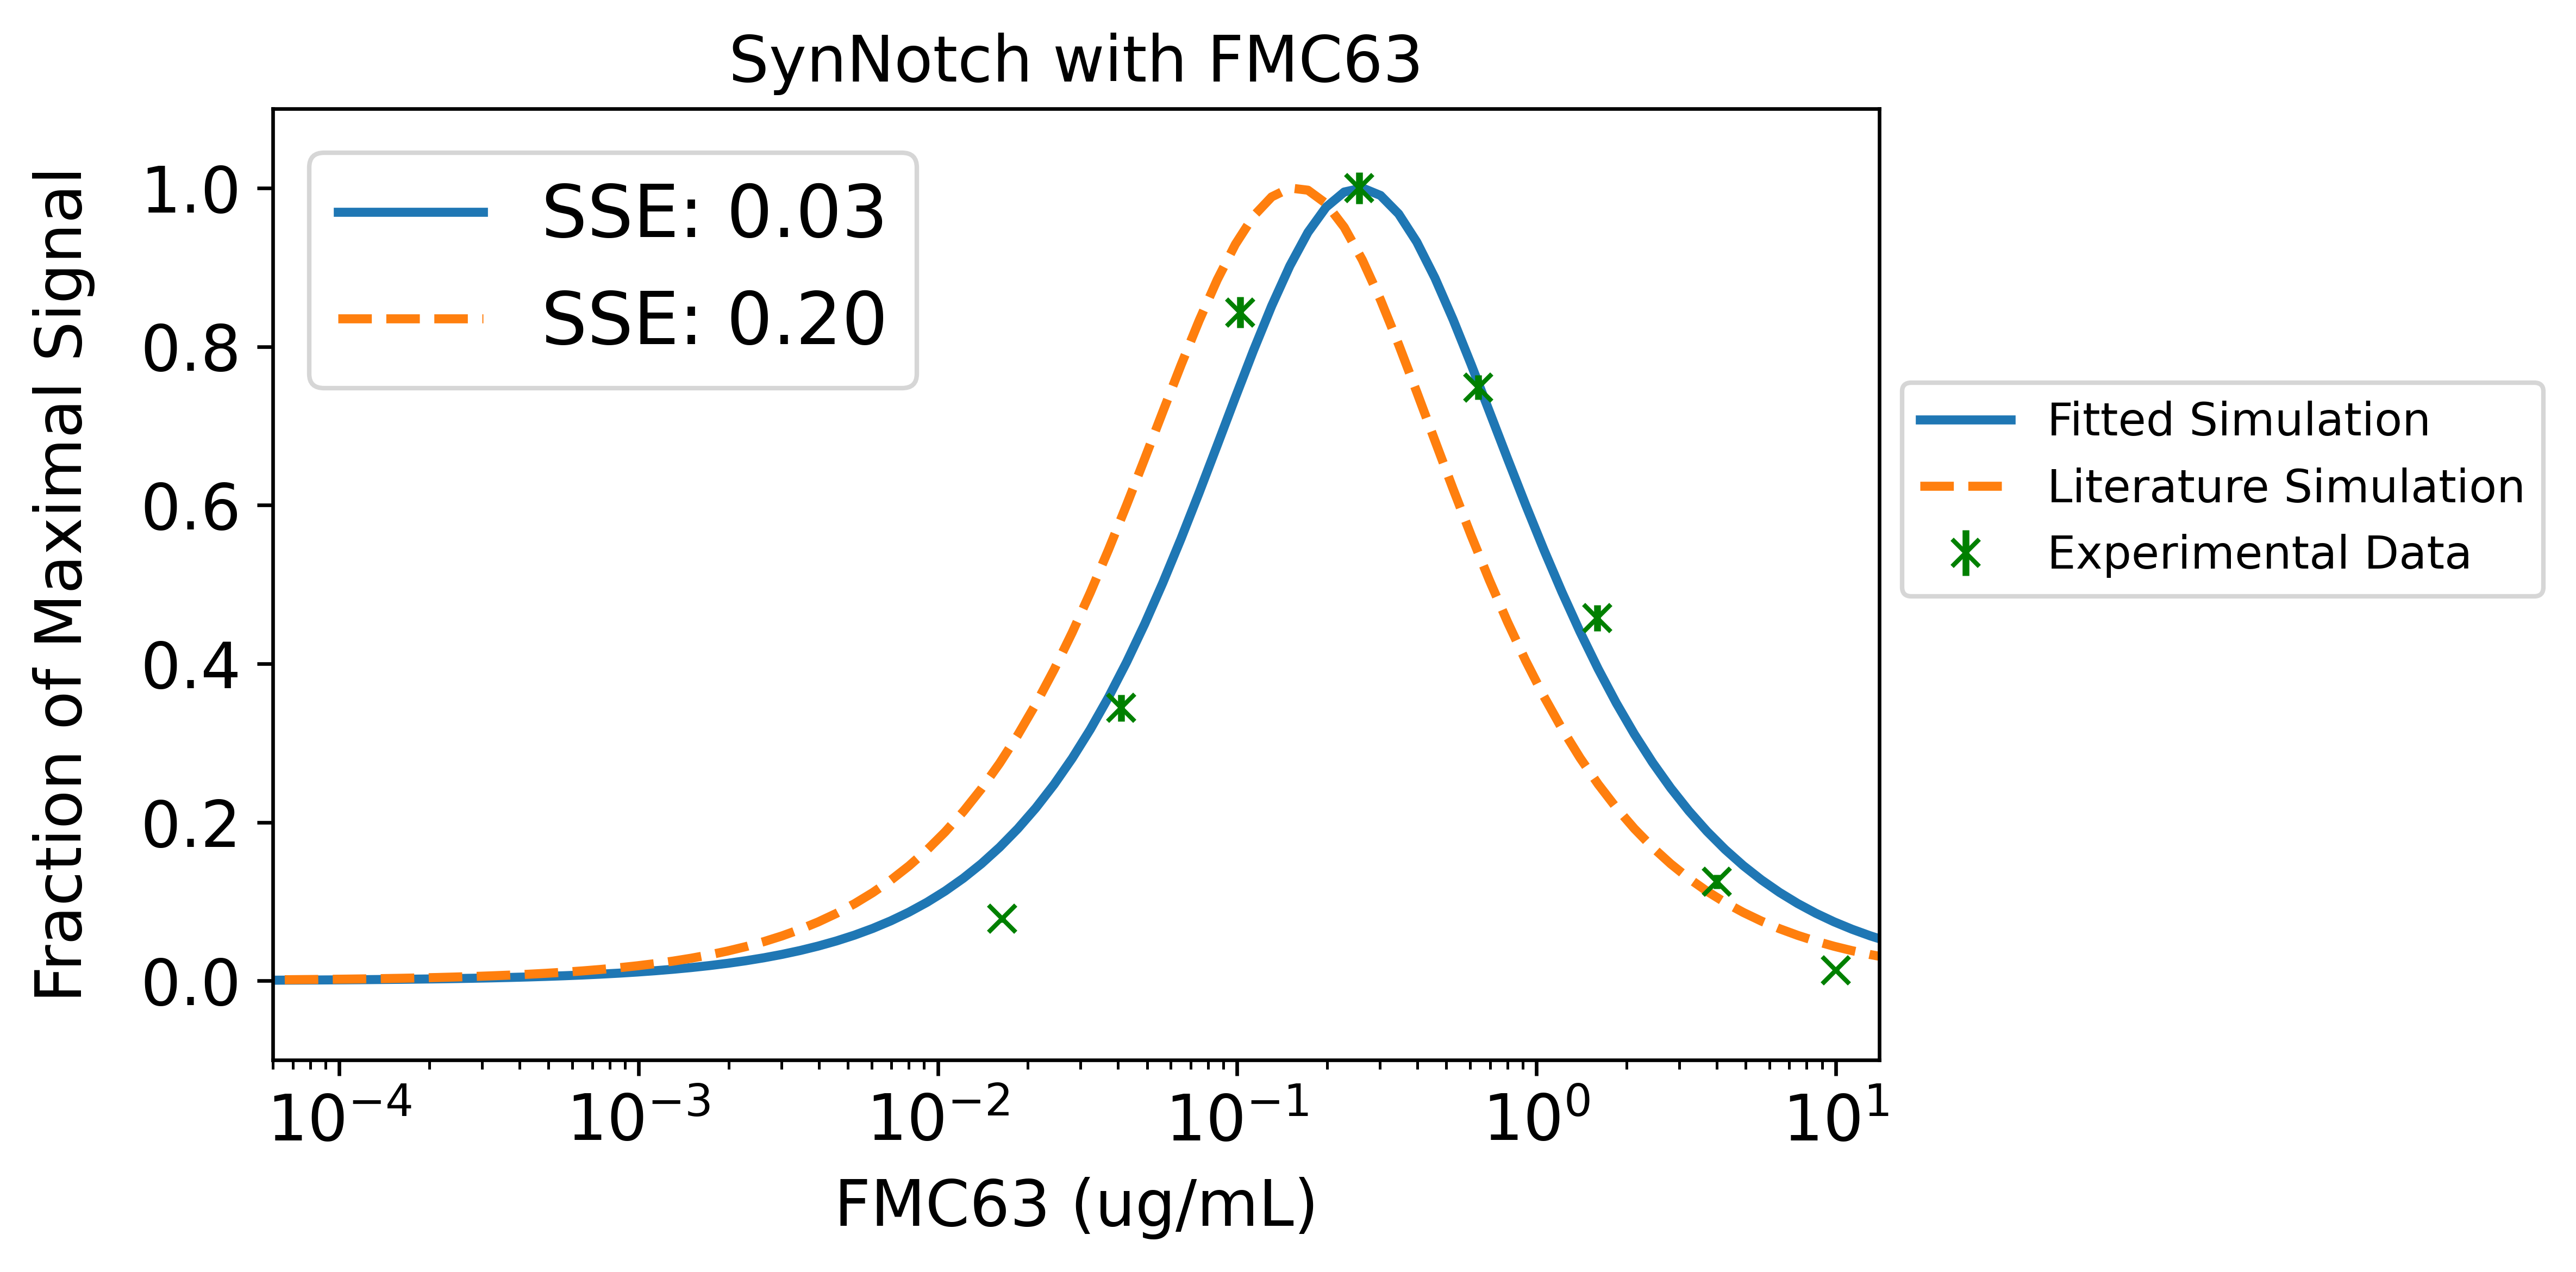

In [219]:
fig = plt.figure(figsize=(8, 4), dpi=600)
gs1 = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs1[0])

lines = []
lines += ax.plot(x_cont,y_fit,linewidth=2.0,label='Fitted Simulation')
lines += ax.plot(x_cont,y_hat_cont,'--',linewidth=2.0,label='Literature Simulation')

# ax.plot(x_dots,y_actual_dots,linewidth=2.0,label='Experimental Data')
lines += ax.errorbar(df_data, df_ydata, yerr=df_yerror, fmt='xg',label='Experimental Data')

ax.set_xscale('log')
plt.ylim([-0.1,1.1])
plt.xlim([6*10**-5,1.4*10**1])

if experiment.split("_")[0] == "SN": test = "SynNotch with "
else: test = "CAR T Cell with "
        
title = test + str(experiment.split("_")[1])
x_label = str(experiment.split("_")[1]) + ' (ug/mL)'

plt.title(title, fontsize=14)
plt.xlabel(x_label, fontsize=14,labelpad=5)
plt.ylabel('Fraction of Maximal Signal', fontsize=14,labelpad=10)

ttl = ax.title
ttl.set_position([.5, 1.05])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Shrink current axis by 10%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.6))
leg = Legend(ax, lines[0:2], ['SSE: '+str(error_after),'SSE: '+str(error_before)], loc='center left', bbox_to_anchor=(0, 0.83), fontsize=16)
ax.add_artist(leg)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.3))

#Creating the plot, saving it, and showing it
gs1.tight_layout(fig)
gs1.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig(full_namer)
# plt.savefig(full_namer.split('.png')[0]+'.svg', dpi=600, format='svg')

plt.show()

In [180]:
# Simulate the model over a range
N = 30
log_lower_bound =-8
log_upper_bound = 2
antibody_range_array = np.logspace(-4,2,N) #antibody in nM for simulation
parameter_range_array = np.logspace(log_lower_bound,log_upper_bound,N)

time = np.linspace(0,86400,86400)

X, Y = np.meshgrid(antibody_range_array, parameter_range_array)
Z = np.zeros(X.shape)

row = 0
col = 0


for parameter in parameter_range_array:
    #Variables given for the experimental setup
    Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
    reaction_volume = 150                                     #150 uL reaction volume
    number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
    number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

    #Regular Parameters from before
    receptor = Antibodies['Target'][type_of_antibody]
    number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
    number_of_receptors_per_tumor = int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

    Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                                   (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Antibody = 1 #1 nM, ususal value is a range

    
    k_binding_snap_to_antibody = parameter #TCell.iloc[0][1] * 
    k_release_snap_to_antibody = 0 #TCell.iloc[0][3]
    k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
    k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

    k = [k_binding_snap_to_antibody,\
         k_release_snap_to_antibody,\
         k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor] 
    
    #the for loop to go over the range of the antibody concentrations
    for anti in antibody_range_array:
        Initial[1] = anti
        C = odeint(rxn,Initial,time)
        Z[row,col] = (float((C[-1,5])))
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-4,2,N)
lin_antibody = lin_antibody * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

lin_parameter = np.linspace(log_lower_bound,log_upper_bound,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_parameter)
z = Z / Z.max()

In [181]:
np.log10(antibody_range_array.min())

-4.0

In [182]:
antibody_range_array.max()

100.0

In [183]:
x = ['{:.1E}'.format(item) for item in antibody_range_array]
y = ['{:.1E}'.format(item) for item in parameter_range_array]

df2 = pd.DataFrame(data=z.T, columns = y)
df2['xVal'] = x
df2.set_index(['xVal'],inplace=True)
df3 = df2.iloc[::-1]
Z1 = df3.values

x_vals = np.logspace(np.log10(parameter_range_array.min()), np.log10(parameter_range_array.max()), 30)
y_vals = np.logspace(np.log10(antibody_range_array.min()), np.log10(antibody_range_array.max()), 30)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in x_vals]
ty = [u"${}$".format(tick.format_data(x)) for x in y_vals]

In [184]:
# tx2 = ['$10^{−8}$','','',\
#       '$10^{−7}$','','',\
#       '$10^{−6}$','','',\
#       '$10^{−5}$','','',\
#       '$10^{−4}$','','',\
#       '$10^{−3}$','','',\
#       '$10^{−2}$','','',\
#       '$10^{−1}$','','',\
#       '$10^{0}$','','',\
#       '$10^{1}$','','']

tx = ['$10^{−8}$','','',\
      '','','',\
      '$10^{−6}$','','',\
      '','','',\
      '$10^{−4}$','','',\
      '','','',\
      '$10^{−2}$','','',\
      '','','',\
      '$10^{0}$','','',\
      '','','$10^{2}$']

ty = ['','$10^{2}$','','','','',\
      '$10^{1}$','','','','',\
      '$10^{0}$','','','','',\
      '$10^{−1}$','','','','',\
      '$10^{-2}$','','','','',\
      '$10^{-3}$','','','']

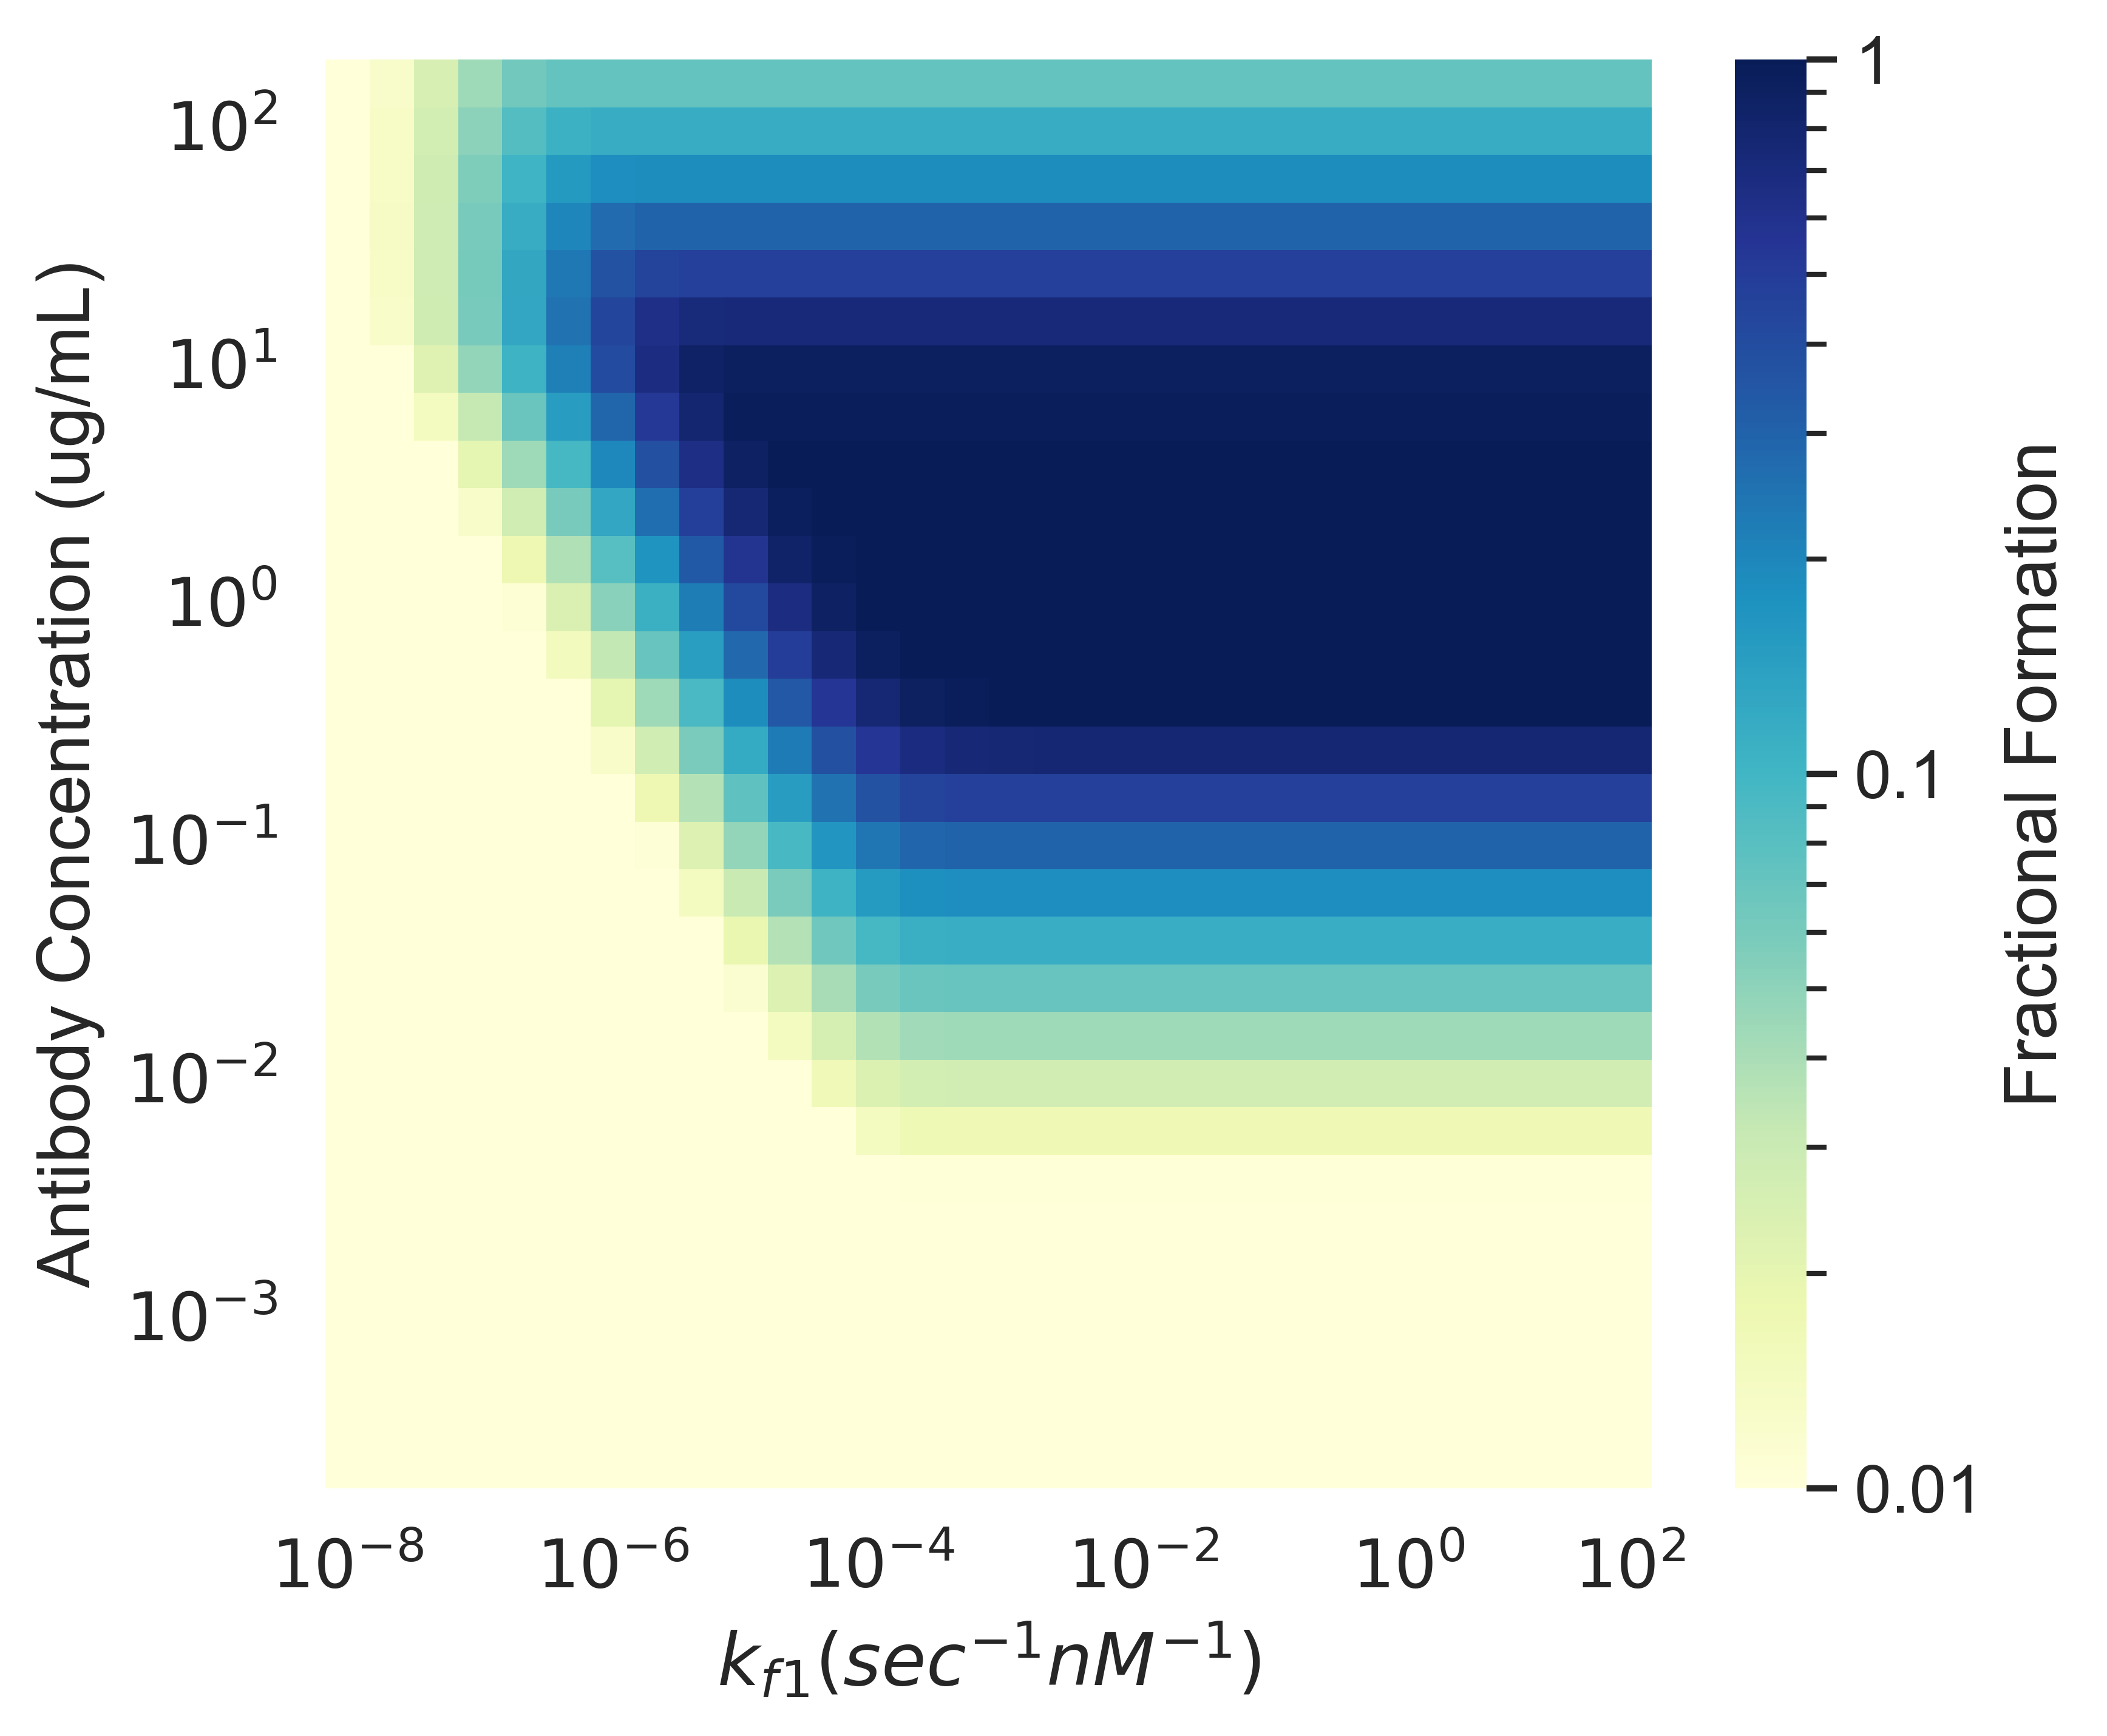

In [185]:
fig = plt.figure(figsize=(6, 5), dpi=600)

cbar_ticks = [math.pow(10, i) for i in range(-2,1)]

# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu', fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu', fmt='.2g',norm=LogNorm(vmin=0.01, vmax=Z1.max()),\
                 cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .1, 1])
cbar.set_ticklabels(['0.01', '0.1','1'])
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)

ax.tick_params(left=False, bottom=False)
ax.tick_params(axis = 'x', labelrotation = 0)
ax.tick_params(axis = 'y', labelrotation = 0)

sns.set(font_scale=1.2)
ax.set(xlabel='$k{_f}{_1} (sec^{-1}nM^{-1})$', ylabel='Antibody Concentration (ug/mL)')
full_namer = 'Figures/ParameterScan_kf1.png'
plt.tight_layout()
plt.savefig(full_namer)
plt.show()

In [166]:
# Simulate the model over a range
N = 30
log_lower_bound = 3
log_upper_bound = 6.2
antibody_range_array = np.logspace(-4,2,N) #antibody in nM for simulation
log_antibody = antibody_range_array * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

parameter_range_array = np.logspace(log_lower_bound,log_upper_bound,N)

time = np.linspace(0,86400,86400)

X, Y = np.meshgrid(antibody_range_array, parameter_range_array)
Z = np.zeros(X.shape)

row = 0
col = 0


for parameter in parameter_range_array:
    #Variables given for the experimental setup
    Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
    reaction_volume = 150                                     #150 uL reaction volume
    number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
    number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

    #Regular Parameters from before
    receptor = Antibodies['Target'][type_of_antibody]
    number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
    number_of_receptors_per_tumor = parameter #int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

    Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                                   (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Antibody = 1 #1 nM, ususal value is a range

    Initial = [Concentration_of_T_Cells,0,Concentration_of_Tumor_Cells,0,0,0]
    
    k_binding_snap_to_antibody = TCell.iloc[0][1] 
    k_release_snap_to_antibody = 0 #TCell.iloc[0][3]
    k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
    k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

    k = [k_binding_snap_to_antibody,\
         k_release_snap_to_antibody,\
         k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor] 
    
    #the for loop to go over the range of the antibody concentrations
    for anti in antibody_range_array:
        Initial[1] = anti
        C = odeint(rxn,Initial,time)
        Z[row,col] = (float((C[-1,5])))
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-4,2,N)
lin_antibody = lin_antibody * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

lin_parameter = np.linspace(log_lower_bound,log_upper_bound,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_parameter)
z = Z / Z.max()

In [167]:
y = ['{:.1E}'.format(item) for item in parameter_range_array]
df2 = pd.DataFrame(data=z.T, columns = y)
x = ['{:.1E}'.format(item) for item in log_antibody]
df2['xVal'] = x
df2.set_index(['xVal'],inplace=True)
df3 = df2.iloc[::-1]

In [168]:
x_vals = np.logspace(np.log10(parameter_range_array.min()), np.log10(parameter_range_array.max()), 30)
y_vals = np.logspace(np.log10(antibody_range_array.min()), np.log10(antibody_range_array.max()), 30)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in x_vals]
ty = [u"${}$".format(tick.format_data(x)) for x in y_vals]

In [169]:
ty

['$10^{−4}$',
 '$1.610262028 \\times 10^{−4}$',
 '$2.592943797 \\times 10^{−4}$',
 '$4.175318937 \\times 10^{−4}$',
 '$6.723357537 \\times 10^{−4}$',
 '$1.082636734 \\times 10^{−3}$',
 '$1.743328822 \\times 10^{−3}$',
 '$2.807216204 \\times 10^{−3}$',
 '$4.520353656 \\times 10^{−3}$',
 '$7.278953844 \\times 10^{−3}$',
 '$1.172102297 \\times 10^{−2}$',
 '$1.887391822 \\times 10^{−2}$',
 '$3.039195382 \\times 10^{−2}$',
 '$4.893900918 \\times 10^{−2}$',
 '$7.880462816 \\times 10^{−2}$',
 '$1.268961003 \\times 10^{−1}$',
 '$2.043359718 \\times 10^{−1}$',
 '$3.290344562 \\times 10^{−1}$',
 '$5.298316906 \\times 10^{−1}$',
 '$8.531678524 \\times 10^{−1}$',
 '$1.373823796$',
 '$2.212216291$',
 '$3.56224789$',
 '$5.73615251$',
 '$9.236708572$',
 '$1.487352107 \\times 10^{1}$',
 '$2.39502662 \\times 10^{1}$',
 '$3.856620421 \\times 10^{1}$',
 '$6.210169419 \\times 10^{1}$',
 '$10^{2}$']

In [170]:
tx = ['$10^{3}$','','','','','','','','',\
      '$10^{4}$','','','','','','','','',\
      '$10^{5}$','','','','','','','','',\
      '$10^{6}$','','']

ty = ['','$10^{1}$','','','','',\
      '$10^{0}$','','','','',\
      '$10^{−1}$','','','','',\
      '$10^{−2}$','','','','',\
      '$10^{-3}$','','','','',\
      '$10^{-4}$','','','']

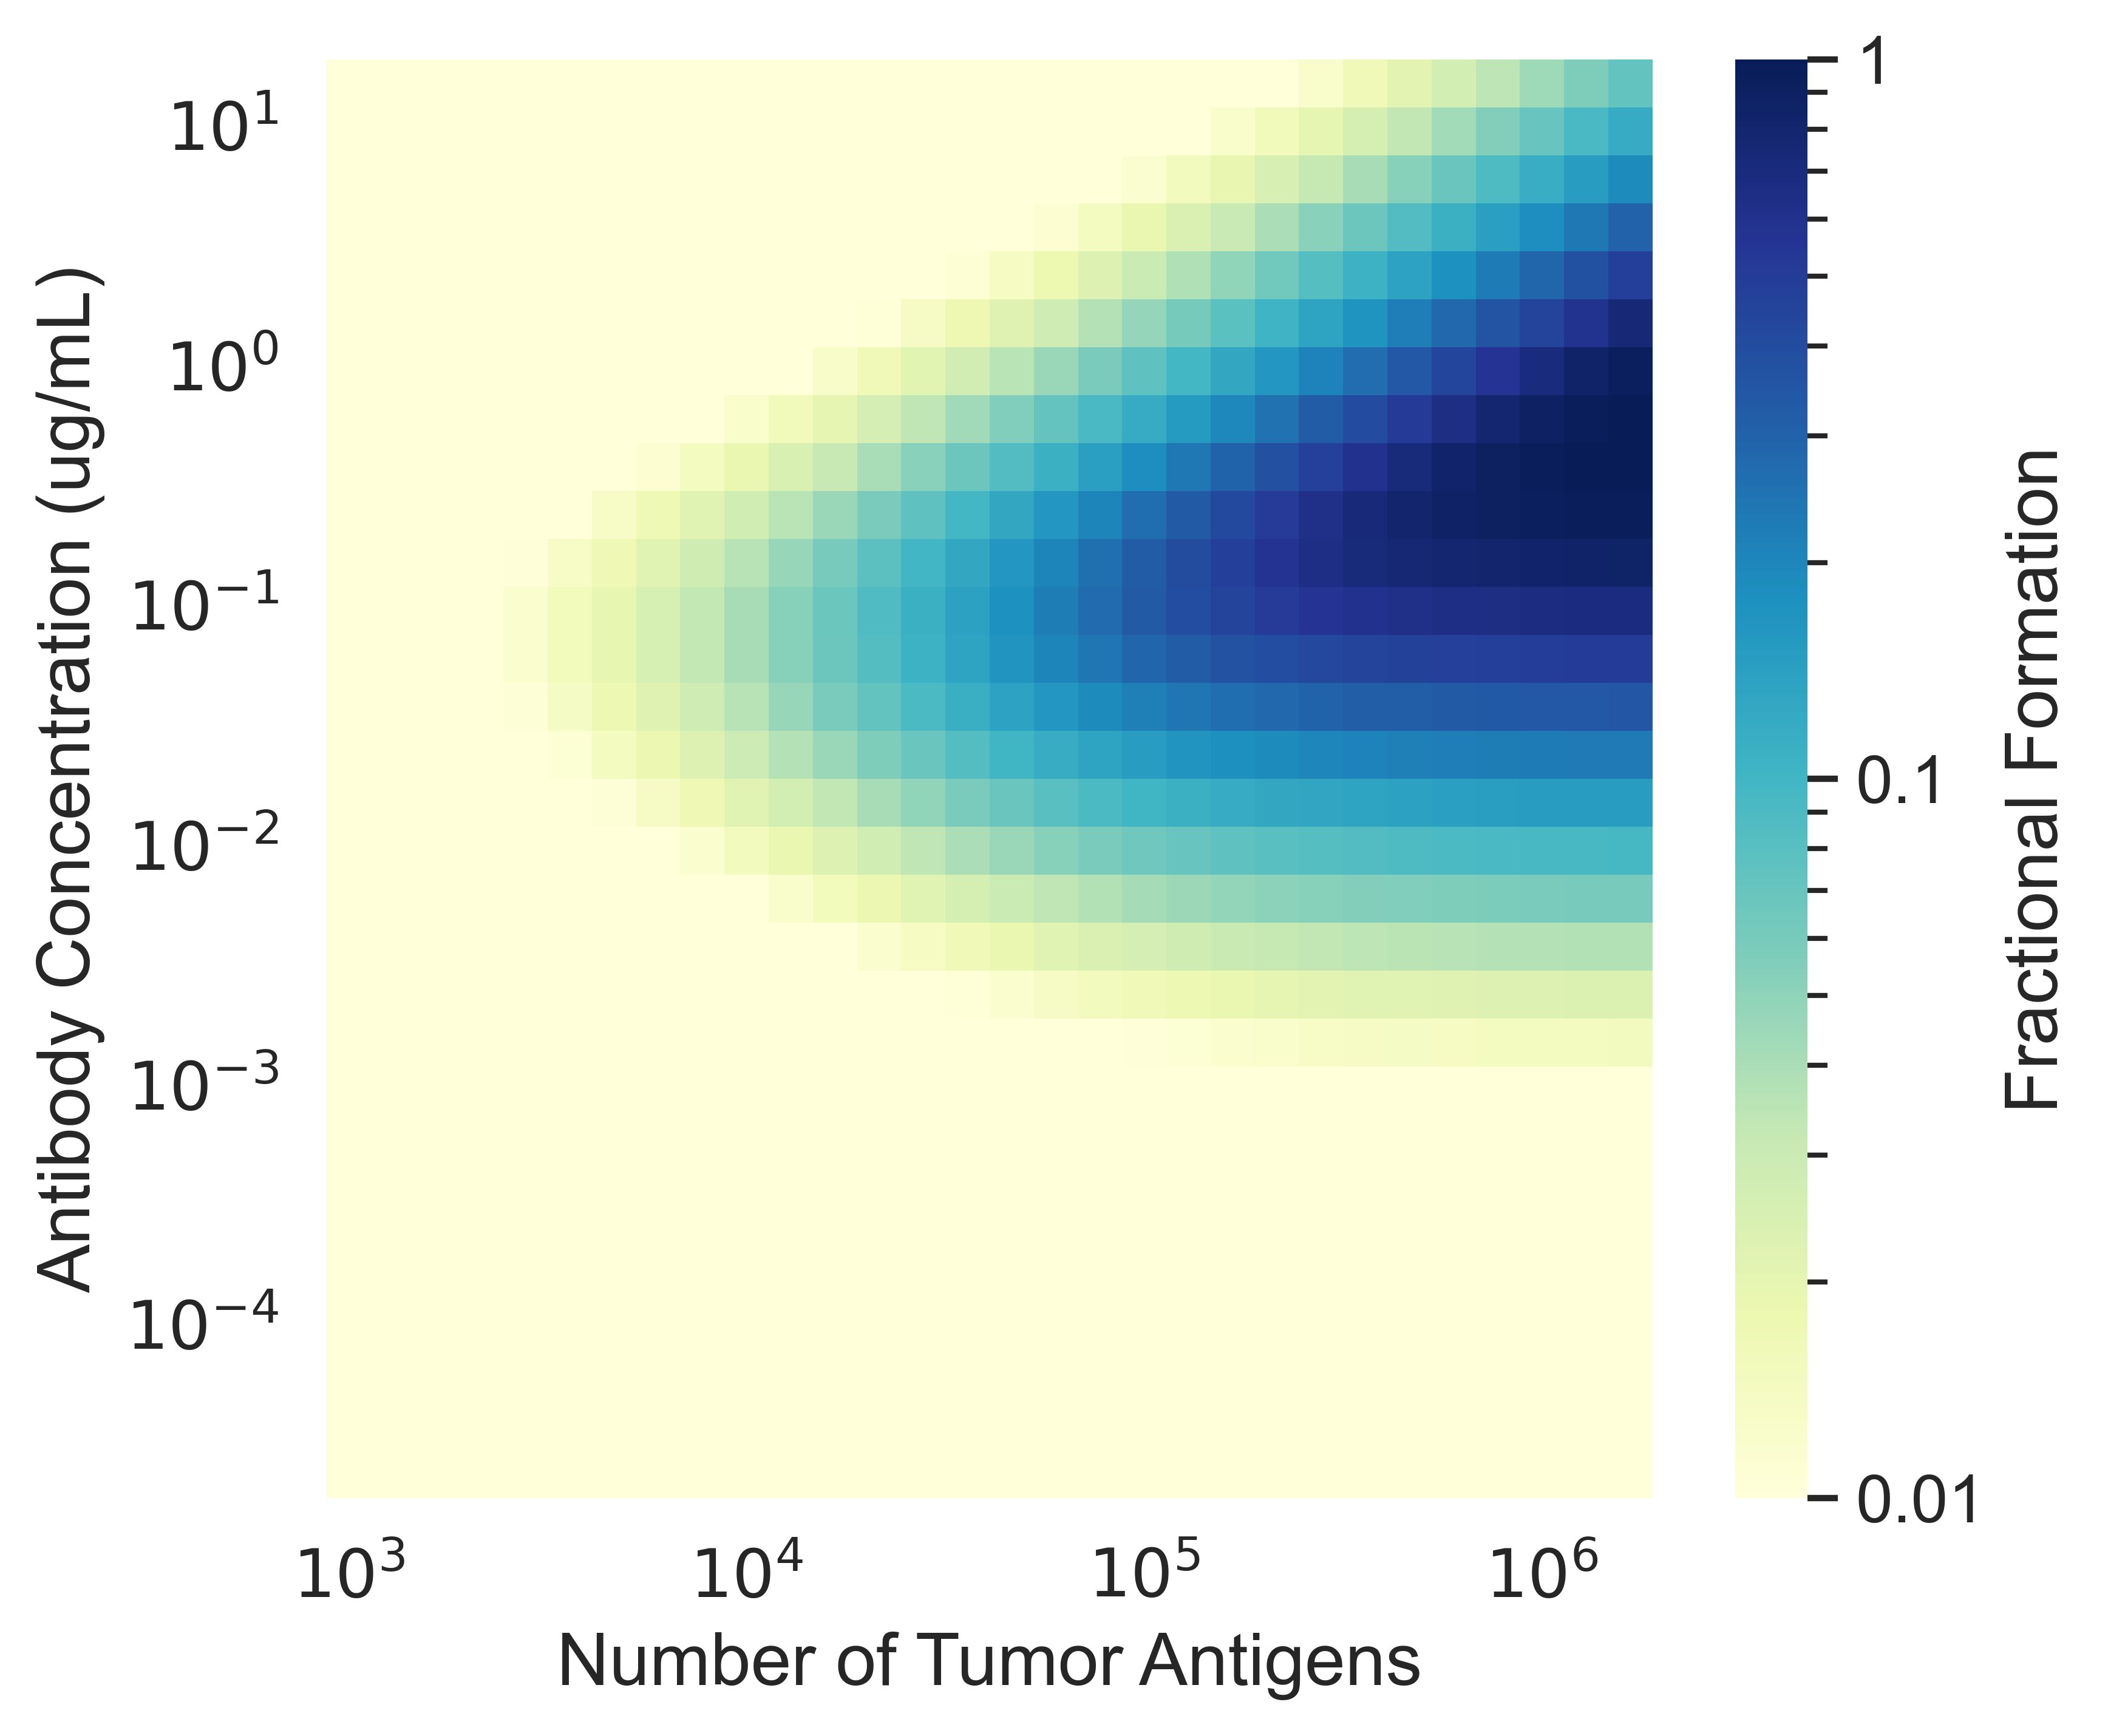

In [173]:
fig = plt.figure(figsize=(6, 5), dpi=600)
cbar_ticks = [math.pow(10, i) for i in range(-2,1)]

Z1 = df3.values
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)

# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
#                  vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
                 fmt='.2g',norm=LogNorm(vmin=0.01, vmax=Z1.max()),\
                 cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
                 vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)


cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .1, 1])
cbar.set_ticklabels(['0.01', '0.1','1'])
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)
ax.tick_params(left=False, bottom=False)
ax.tick_params(axis = 'x', labelrotation = 0)
ax.tick_params(axis = 'y', labelrotation = 0)

# ax.set_yscale('log')
# ax.set_xscale('log')
sns.set(font_scale=1.2)
ax.set(xlabel='Number of Tumor Antigens', ylabel='Antibody Concentration (ug/mL)')
full_namer = 'Figures/ParameterScan_TumorAntigen.png'
plt.tight_layout()
plt.savefig(full_namer)
plt.show()

In [186]:
# Simulate the model over a range
N = 30
log_lower_bound =-5
log_upper_bound = 1
antibody_range_array = np.logspace(-4,2,N) #antibody in nM for simulation
parameter_range_array = np.logspace(log_lower_bound,log_upper_bound,N)

time = np.linspace(0,86400,86400)

X, Y = np.meshgrid(antibody_range_array, parameter_range_array)
Z = np.zeros(X.shape)

row = 0
col = 0


for parameter in parameter_range_array:
    #Variables given for the experimental setup
    Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
    reaction_volume = 150                                     #150 uL reaction volume
    number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
    number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

    #Regular Parameters from before
    receptor = Antibodies['Target'][type_of_antibody]
    number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
    number_of_receptors_per_tumor = int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

    Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                                   (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
    Concentration_of_Antibody = 1 #1 nM, ususal value is a range

    
    k_binding_snap_to_antibody = TCell.iloc[0][1]  
    k_release_snap_to_antibody = TCell.iloc[0][3] * parameter
    k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
    k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

    k = [k_binding_snap_to_antibody,\
         k_release_snap_to_antibody,\
         k_binding_antibody_to_tumor,\
         k_release_antibody_to_tumor] 
    
    #the for loop to go over the range of the antibody concentrations
    for anti in antibody_range_array:
        Initial[1] = anti
        C = odeint(rxn,Initial,time)
        Z[row,col] = (float((C[-1,5])))
        col += 1
    col = 0
    row += 1
    
#Collapse our Logspace to Linspace because matplotlib has difficulty with logspace plotting
lin_antibody = np.linspace(-4,2,N)
lin_antibody = lin_antibody * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

lin_parameter = np.linspace(log_lower_bound,log_upper_bound,N)
lin_X, lin_Y = np.meshgrid(lin_antibody, lin_parameter)
z = Z / Z.max()

In [187]:
y = ['{:.1E}'.format(item) for item in parameter_range_array]
df2 = pd.DataFrame(data=z.T, columns = y)
x = ['{:.1E}'.format(item) for item in antibody_range_array]
df2['xVal'] = x
df2.set_index(['xVal'],inplace=True)
df3 = df2.iloc[::-1]

In [188]:
x_vals = np.logspace(np.log10(parameter_range_array.min()), np.log10(parameter_range_array.max()), 30)
y_vals = np.logspace(np.log10(antibody_range_array.min()), np.log10(antibody_range_array.max()), 30)

tick = ticker.ScalarFormatter(useOffset=False, useMathText=True)
tick.set_powerlimits((0,0))

tx = [u"${}$".format(tick.format_data(x)) for x in x_vals]
ty = [u"${}$".format(tick.format_data(x)) for x in y_vals]

In [189]:
ty

['$10^{−4}$',
 '$1.610262028 \\times 10^{−4}$',
 '$2.592943797 \\times 10^{−4}$',
 '$4.175318937 \\times 10^{−4}$',
 '$6.723357537 \\times 10^{−4}$',
 '$1.082636734 \\times 10^{−3}$',
 '$1.743328822 \\times 10^{−3}$',
 '$2.807216204 \\times 10^{−3}$',
 '$4.520353656 \\times 10^{−3}$',
 '$7.278953844 \\times 10^{−3}$',
 '$1.172102297 \\times 10^{−2}$',
 '$1.887391822 \\times 10^{−2}$',
 '$3.039195382 \\times 10^{−2}$',
 '$4.893900918 \\times 10^{−2}$',
 '$7.880462816 \\times 10^{−2}$',
 '$1.268961003 \\times 10^{−1}$',
 '$2.043359718 \\times 10^{−1}$',
 '$3.290344562 \\times 10^{−1}$',
 '$5.298316906 \\times 10^{−1}$',
 '$8.531678524 \\times 10^{−1}$',
 '$1.373823796$',
 '$2.212216291$',
 '$3.56224789$',
 '$5.73615251$',
 '$9.236708572$',
 '$1.487352107 \\times 10^{1}$',
 '$2.39502662 \\times 10^{1}$',
 '$3.856620421 \\times 10^{1}$',
 '$6.210169419 \\times 10^{1}$',
 '$10^{2}$']

In [190]:
tx = ['$10^{-5}$','','','','','','$10^{-4}$','','',\
      '','','','$10^{-3}$','','','','','',\
      '$10^{-2}$','','','','','','$10^{-1}$','','',\
      '','','$10^{0}$']

ty = ['','$10^{2}$','','','','',\
      '$10^{1}$','','','','',\
      '$10^{0}$','','','','',\
      '$10^{−1}$','','','','',\
      '$10^{-2}$','','','','',\
      '$10^{-3}$','','','']

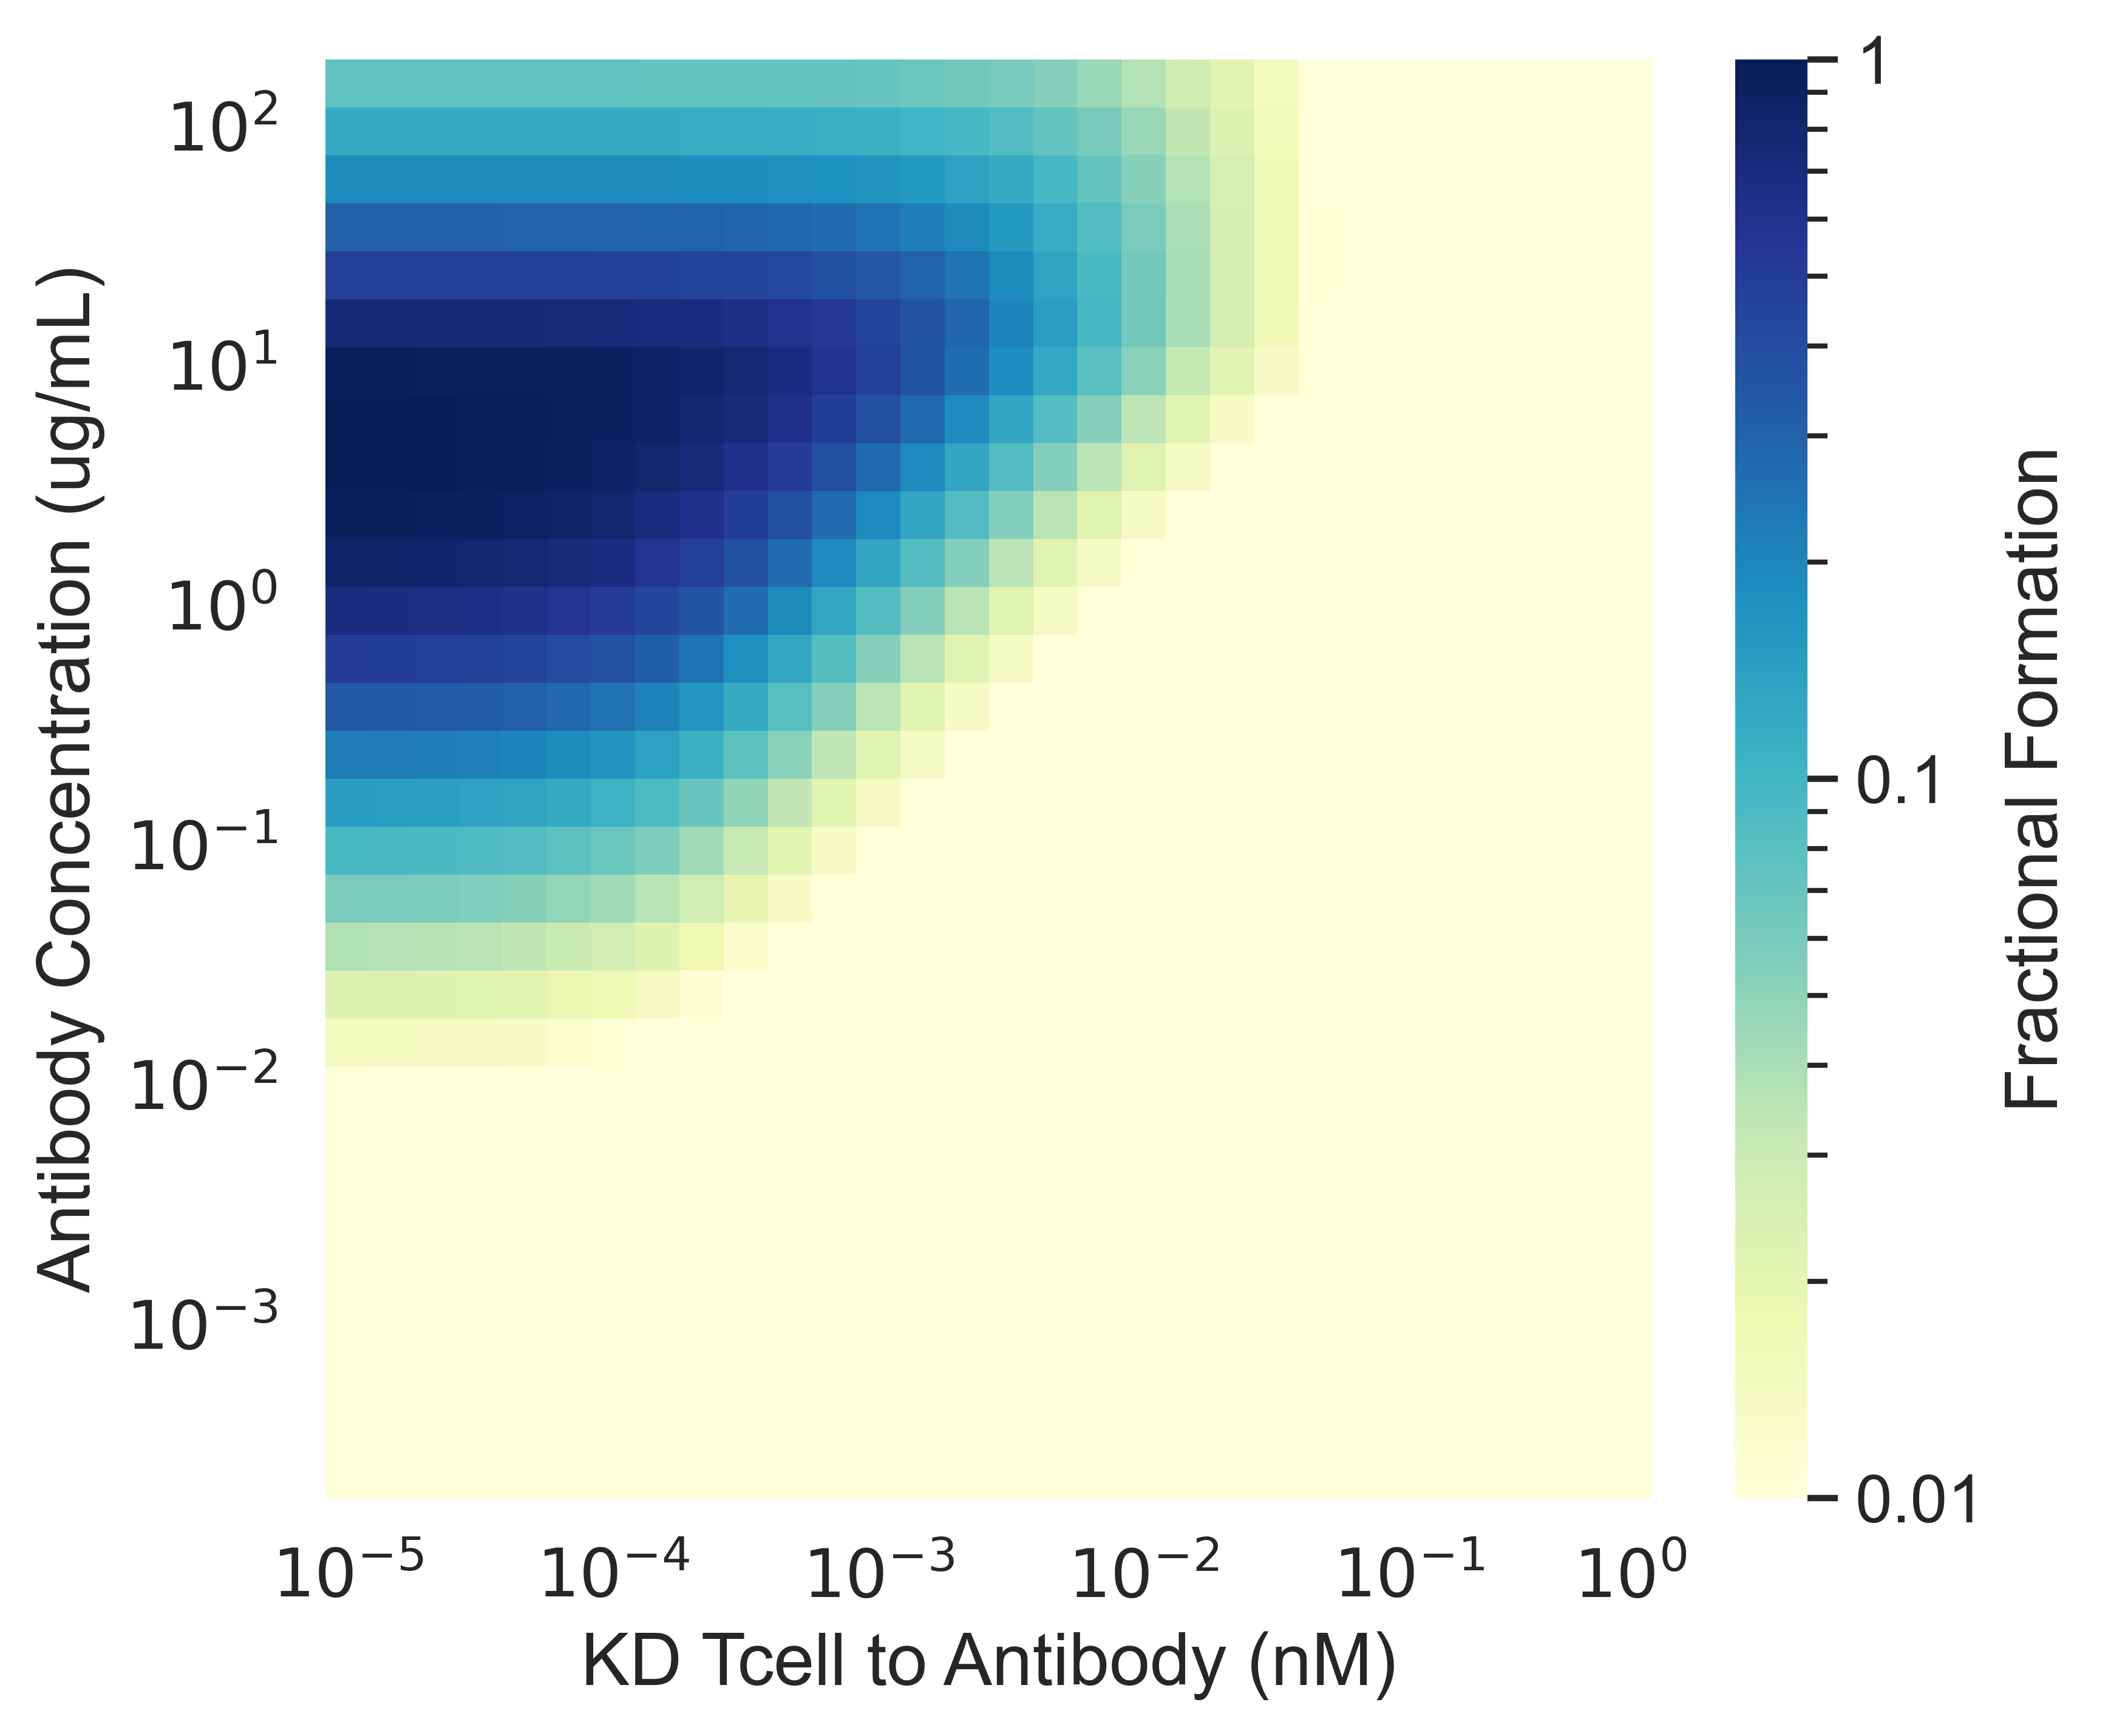

In [191]:
fig = plt.figure(figsize=(6, 5), dpi=600)

cbar_ticks = [math.pow(10, i) for i in range(-2,1)]

Z1 = df3.values
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)

# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
#                  vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
                 fmt='.2g',norm=LogNorm(vmin=0.01, vmax=Z1.max()),\
                 cbar_kws={"ticks": cbar_ticks,'label': 'Fractional Formation'},\
                 vmin = 0.01, vmax=1, xticklabels=tx, yticklabels=ty)

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .1, 1])
cbar.set_ticklabels(['0.01', '0.1','1'])
# ax = sns.heatmap(df3, linewidth=0,cmap='YlGnBu',\
#                  fmt='.2g',norm=LogNorm(vmin=Z1.min(), vmax=Z1.max()),\
#                  cbar_kws={"ticks": cbar_ticks},vmin = 0.01, vmax=1)
ax.tick_params(left=False, bottom=False)
ax.tick_params(axis = 'x', labelrotation = 0)
ax.tick_params(axis = 'y', labelrotation = 0)

# ax.set_yscale('log')
# ax.set_xscale('log')
sns.set(font_scale=1.2)
ax.set(xlabel='KD Tcell to Antibody (nM)', ylabel='Antibody Concentration (ug/mL)')
full_namer = 'Figures/ParameterScan_kD.png'
plt.tight_layout()
plt.savefig(full_namer)
plt.show()